# Malware Image Classification with CNN

In [1]:
import mt_util as mt
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

## Create Images from Files
In this section I've selected my drivers folder for my system because there should be a good number of binary type files. I use the mt_util library to image an entire system folder.  The default output will create a folder called /imgs. I'll use this folder to begin my EDA work. 

In [2]:
# src_path = 'C:\Drivers'
# mt.imgs_fr_dir(src_path)


## EDA

In [3]:
# Create the pandas DataFrame from object dictionary
df = pd.DataFrame([o.__dict__ for o in mt.get_files('imgs')])

# print dataframe.
df.head(5)

,path,size,file_name,file_ext
0,imgs\0000.ui.forms.png,8695,0000.ui.forms.png,.png
1,imgs\0000.ui.strings.png,941,0000.ui.strings.png,.png
2,imgs\0401.ui.forms.png,1319,0401.ui.forms.png,.png
3,imgs\0401.ui.strings.png,6047,0401.ui.strings.png,.png
4,imgs\0404.ui.forms.png,1391,0404.ui.forms.png,.png


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       1271 non-null   object
 1   size       1271 non-null   int64 
 2   file_name  1271 non-null   object
 3   file_ext   1271 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.8+ KB


In [9]:
def getHWdim(size):
    x = int(math.sqrt(size))
    return x 


Much like hashing a file in malware analysis to ensure other researchers can identify with specificity which specimen under study is being analyzed, I thought it necessary to develop an algorythm that preserves the attributes of the original file to the extent possible. For this reason I opted to take the square root of the file size to determine the width and height dimenssions. I leave the resizing options to the data scientist. To find a suitable data set for my initial experiments I need survey file size and image dimensions.

I create a dimension feature to add to the dataframe. The reason I need a dimension feature is to search for images of files closest to 200*200. This can provide the optimal size for use with a CNN [4][8]. My goal is to limit resizing if possible but if required I will opt for zero padding.[7] I will only need to find one dimension since the square root of the file size since is used by the mt_util to creates perfect square images from the file input.

In [10]:
df['dim'] = df['size'].apply(lambda x: getHWdim(x))
df

,path,size,file_name,file_ext,dim
0,imgs\0000.ui.forms.png,8695,0000.ui.forms.png,.png,93
1,imgs\0000.ui.strings.png,941,0000.ui.strings.png,.png,30
2,imgs\0401.ui.forms.png,1319,0401.ui.forms.png,.png,36
3,imgs\0401.ui.strings.png,6047,0401.ui.strings.png,.png,77
4,imgs\0404.ui.forms.png,1391,0404.ui.forms.png,.png,37
...,...,...,...,...,...
1266,imgs\_nvppo.dll.png,788152,_nvppo.dll.png,.png,887
1267,imgs\_nvspcaps64.dll.png,1470652,_nvspcaps64.dll.png,.png,1212
1268,imgs\_nvspserviceplugin64.dll.png,846753,_nvspserviceplugin64.dll.png,.png,920
1269,imgs\_nvtopps.dll.png,4396165,_nvtopps.dll.png,.png,2096


Next I will extract the original file type as per my operating system desiganted extension. I do this with a simple lambda that parses out the file extension in the path name. The mt_util preserves the original file name in the output file name by adding the .png extension to the original file. All that is needed to return the original file name is to split the path on '.' and take the second to last string, shown in the lambda below. Then a new feature can be added to the dataframe.

In [13]:
def getFileType(x):
    ss = x.split('.')
    return ss[len(ss) - 2]

In [15]:
df['file_type'] = df['path'].apply(lambda x: getFileType(x))
df

,path,size,file_name,file_ext,dim,file_type
0,imgs\0000.ui.forms.png,8695,0000.ui.forms.png,.png,93,forms
1,imgs\0000.ui.strings.png,941,0000.ui.strings.png,.png,30,strings
2,imgs\0401.ui.forms.png,1319,0401.ui.forms.png,.png,36,forms
3,imgs\0401.ui.strings.png,6047,0401.ui.strings.png,.png,77,strings
4,imgs\0404.ui.forms.png,1391,0404.ui.forms.png,.png,37,forms
...,...,...,...,...,...,...
1266,imgs\_nvppo.dll.png,788152,_nvppo.dll.png,.png,887,dll
1267,imgs\_nvspcaps64.dll.png,1470652,_nvspcaps64.dll.png,.png,1212,dll
1268,imgs\_nvspserviceplugin64.dll.png,846753,_nvspserviceplugin64.dll.png,.png,920,dll
1269,imgs\_nvtopps.dll.png,4396165,_nvtopps.dll.png,.png,2096,dll


In [16]:
df.file_type.value_counts()

dll     325
png     125
dl_      75
exe      74
pak      57
       ... 
blb       1
JSON      1
mc        1
h         1
tga       1
Name: file_type, Length: 75, dtype: int64

## EDA initial Results
As shown above we about 400 samples for training if we use dll and exe files. This is just under half of what we need to get a suitable data set based on my research [9], if attempting a basic CNN architecture. This may support the one-shot method purposed by Hiaso et al. [1] 

In [18]:
sys32 = 'C:\Windows\System32'
# Create the pandas DataFrame from object dictionary
sys32_df = pd.DataFrame([o.__dict__ for o in mt.get_files(sys32)])

# print dataframe.
sys32_df.head(5)

,path,size,file_name,file_ext
0,C:\Windows\System32\07409496-a423-4a3e-b620-2c...,25960,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,.dll
1,C:\Windows\System32\0ae3b998-9a38-4b72-a4c4-06...,25968,0ae3b998-9a38-4b72-a4c4-06849441518d_Servicing...,.dll
2,C:\Windows\System32\4545ffe2-0dc4-4df4-9d02-29...,25952,4545ffe2-0dc4-4df4-9d02-299ef204635e_hvsocket.dll,.dll
3,C:\Windows\System32\69fe178f-26e7-43a9-aa7d-2b...,25952,69fe178f-26e7-43a9-aa7d-2b616b672dde_eventlogs...,.dll
4,C:\Windows\System32\6bea57fb-8dfb-4177-9ae8-42...,25968,6bea57fb-8dfb-4177-9ae8-42e8b3529933_RuntimeDe...,.dll


In [19]:
sys32_df

,path,size,file_name,file_ext
0,C:\Windows\System32\07409496-a423-4a3e-b620-2c...,25960,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,.dll
1,C:\Windows\System32\0ae3b998-9a38-4b72-a4c4-06...,25968,0ae3b998-9a38-4b72-a4c4-06849441518d_Servicing...,.dll
2,C:\Windows\System32\4545ffe2-0dc4-4df4-9d02-29...,25952,4545ffe2-0dc4-4df4-9d02-299ef204635e_hvsocket.dll,.dll
3,C:\Windows\System32\69fe178f-26e7-43a9-aa7d-2b...,25952,69fe178f-26e7-43a9-aa7d-2b616b672dde_eventlogs...,.dll
4,C:\Windows\System32\6bea57fb-8dfb-4177-9ae8-42...,25968,6bea57fb-8dfb-4177-9ae8-42e8b3529933_RuntimeDe...,.dll
...,...,...,...,...
17310,C:\Windows\System32\zh-TW\msprivs.dll.mui,3584,msprivs.dll.mui,.mui
17311,C:\Windows\System32\zh-TW\SyncRes.dll.mui,13824,SyncRes.dll.mui,.mui
17312,C:\Windows\System32\zh-TW\Windows.Media.Speech...,6656,Windows.Media.Speech.UXRes.dll.mui,.mui
17313,C:\Windows\System32\zh-TW\windows.ui.xaml.dll.mui,11776,windows.ui.xaml.dll.mui,.mui


In [20]:
sys32_df.file_ext.value_counts()

.dll    4670
.mui    2854
.cat    2416
.sys     911
.inf     836
        ... 
.lex       1
.mbn       1
.e06       1
.e04       1
.4         1
Name: file_ext, Length: 181, dtype: int64

In [21]:
mt.imgs_fr_dir(sys32, 'sys32imgs')

PermissionError: [Errno 13] Permission denied: 'C:\\Windows\\System32\\catroot2\\edb.log'

TODO: add error handling to mt_util for permissions.

In [23]:
# Create the pandas DataFrame from object dictionary
sys32imgs_df = pd.DataFrame([o.__dict__ for o in mt.get_files('sys32imgs')])

# print dataframe.
sys32imgs_df

,path,size,file_name,file_ext
0,sys32imgs\07409496-a423-4a3e-b620-2cfb01a9318d...,8363,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,.png
1,sys32imgs\0ae3b998-9a38-4b72-a4c4-06849441518d...,8383,0ae3b998-9a38-4b72-a4c4-06849441518d_Servicing...,.png
2,sys32imgs\4545ffe2-0dc4-4df4-9d02-299ef204635e...,8433,4545ffe2-0dc4-4df4-9d02-299ef204635e_hvsocket....,.png
3,sys32imgs\69fe178f-26e7-43a9-aa7d-2b616b672dde...,8379,69fe178f-26e7-43a9-aa7d-2b616b672dde_eventlogs...,.png
4,sys32imgs\6bea57fb-8dfb-4177-9ae8-42e8b3529933...,8386,6bea57fb-8dfb-4177-9ae8-42e8b3529933_RuntimeDe...,.png
...,...,...,...,...
6862,sys32imgs\{97C9A618-D40C-40EE-8563-8799D0DB987...,8105,{97C9A618-D40C-40EE-8563-8799D0DB9872}~mfencbd...,.png
6863,sys32imgs\{A6CE337F-CBA5-412D-A06A-D872F2A8F08...,8105,{A6CE337F-CBA5-412D-A06A-D872F2A8F089}~mfencbd...,.png
6864,sys32imgs\{AC93B605-EEAA-4818-9136-9EDA5489749...,6835,{AC93B605-EEAA-4818-9136-9EDA54897497}~mfencbd...,.png
6865,sys32imgs\{C03C9921-D1C8-49D2-83C4-162FBC62CCA...,6814,{C03C9921-D1C8-49D2-83C4-162FBC62CCA8}~mfencrk...,.png


Although I didn't get all 17K, due to exception, I was able to get about 7K images so I will proceed with this data set. I'll use the same lamdas as before to extract features for this data set.

In [27]:
sys32imgs_df['dim'] = sys32imgs_df['size'].apply(lambda x: getHWdim(x))
sys32imgs_df

,path,size,file_name,file_ext,dim
0,sys32imgs\07409496-a423-4a3e-b620-2cfb01a9318d...,8363,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,.png,91
1,sys32imgs\0ae3b998-9a38-4b72-a4c4-06849441518d...,8383,0ae3b998-9a38-4b72-a4c4-06849441518d_Servicing...,.png,91
2,sys32imgs\4545ffe2-0dc4-4df4-9d02-299ef204635e...,8433,4545ffe2-0dc4-4df4-9d02-299ef204635e_hvsocket....,.png,91
3,sys32imgs\69fe178f-26e7-43a9-aa7d-2b616b672dde...,8379,69fe178f-26e7-43a9-aa7d-2b616b672dde_eventlogs...,.png,91
4,sys32imgs\6bea57fb-8dfb-4177-9ae8-42e8b3529933...,8386,6bea57fb-8dfb-4177-9ae8-42e8b3529933_RuntimeDe...,.png,91
...,...,...,...,...,...
6862,sys32imgs\{97C9A618-D40C-40EE-8563-8799D0DB987...,8105,{97C9A618-D40C-40EE-8563-8799D0DB9872}~mfencbd...,.png,90
6863,sys32imgs\{A6CE337F-CBA5-412D-A06A-D872F2A8F08...,8105,{A6CE337F-CBA5-412D-A06A-D872F2A8F089}~mfencbd...,.png,90
6864,sys32imgs\{AC93B605-EEAA-4818-9136-9EDA5489749...,6835,{AC93B605-EEAA-4818-9136-9EDA54897497}~mfencbd...,.png,82
6865,sys32imgs\{C03C9921-D1C8-49D2-83C4-162FBC62CCA...,6814,{C03C9921-D1C8-49D2-83C4-162FBC62CCA8}~mfencrk...,.png,82


In [28]:
sys32imgs_df['file_type'] = sys32imgs_df['path'].apply(lambda x: getFileType(x))
sys32imgs_df

,path,size,file_name,file_ext,dim,file_type
0,sys32imgs\07409496-a423-4a3e-b620-2cfb01a9318d...,8363,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,.png,91,dll
1,sys32imgs\0ae3b998-9a38-4b72-a4c4-06849441518d...,8383,0ae3b998-9a38-4b72-a4c4-06849441518d_Servicing...,.png,91,dll
2,sys32imgs\4545ffe2-0dc4-4df4-9d02-299ef204635e...,8433,4545ffe2-0dc4-4df4-9d02-299ef204635e_hvsocket....,.png,91,dll
3,sys32imgs\69fe178f-26e7-43a9-aa7d-2b616b672dde...,8379,69fe178f-26e7-43a9-aa7d-2b616b672dde_eventlogs...,.png,91,dll
4,sys32imgs\6bea57fb-8dfb-4177-9ae8-42e8b3529933...,8386,6bea57fb-8dfb-4177-9ae8-42e8b3529933_RuntimeDe...,.png,91,dll
...,...,...,...,...,...,...
6862,sys32imgs\{97C9A618-D40C-40EE-8563-8799D0DB987...,8105,{97C9A618-D40C-40EE-8563-8799D0DB9872}~mfencbd...,.png,90,cat
6863,sys32imgs\{A6CE337F-CBA5-412D-A06A-D872F2A8F08...,8105,{A6CE337F-CBA5-412D-A06A-D872F2A8F089}~mfencbd...,.png,90,cat
6864,sys32imgs\{AC93B605-EEAA-4818-9136-9EDA5489749...,6835,{AC93B605-EEAA-4818-9136-9EDA54897497}~mfencbd...,.png,82,cat
6865,sys32imgs\{C03C9921-D1C8-49D2-83C4-162FBC62CCA...,6814,{C03C9921-D1C8-49D2-83C4-162FBC62CCA8}~mfencrk...,.png,82,cat


In [29]:
sys32imgs_df.file_type.value_counts()

dll           3306
cat           2283
exe            586
DLL            223
NLS            112
              ... 
pb               1
InstallLog       1
ime              1
wim              1
dtd              1
Name: file_type, Length: 68, dtype: int64

In [30]:
sys32imgs_df.to_csv('sys32imgs.csv')

In [31]:
df.to_csv('driversimgs.csv')

## EDA inital Conclusion
The lack of samples in the drivers directory caused me to look elswhere for compiled code such as dll and exe. The most common place for compiled code in a Windows system is the System32 directory. I was able find about 3k dll and .5k exe files which is over the minimal threshold of 1k for samples [9]. I will continue on to data sample analysis in my next notebook prior to CNN setup.

### Interesting Discovery
While trying to perform some basic EDA on my images I ran into issues with finding dimensions. It seems some of the files are so large that when trying to process them it triggered an exception in the PIL library. The max pixel size can be set to larger if needed. [7]

In [8]:
# for f in mt.get_files('imgs'):
#     im = Image.open(f.path)
#     w, h = im.size
#     print(f.path, "w:", w, "h:", h)

In [51]:
qf = df.query("dim > 13377")

In [52]:
qf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1067 to 1067
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       1 non-null      object
 1   size       1 non-null      int64 
 2   file_name  1 non-null      object
 3   file_ext   1 non-null      object
 4   dim        1 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 48.0+ bytes


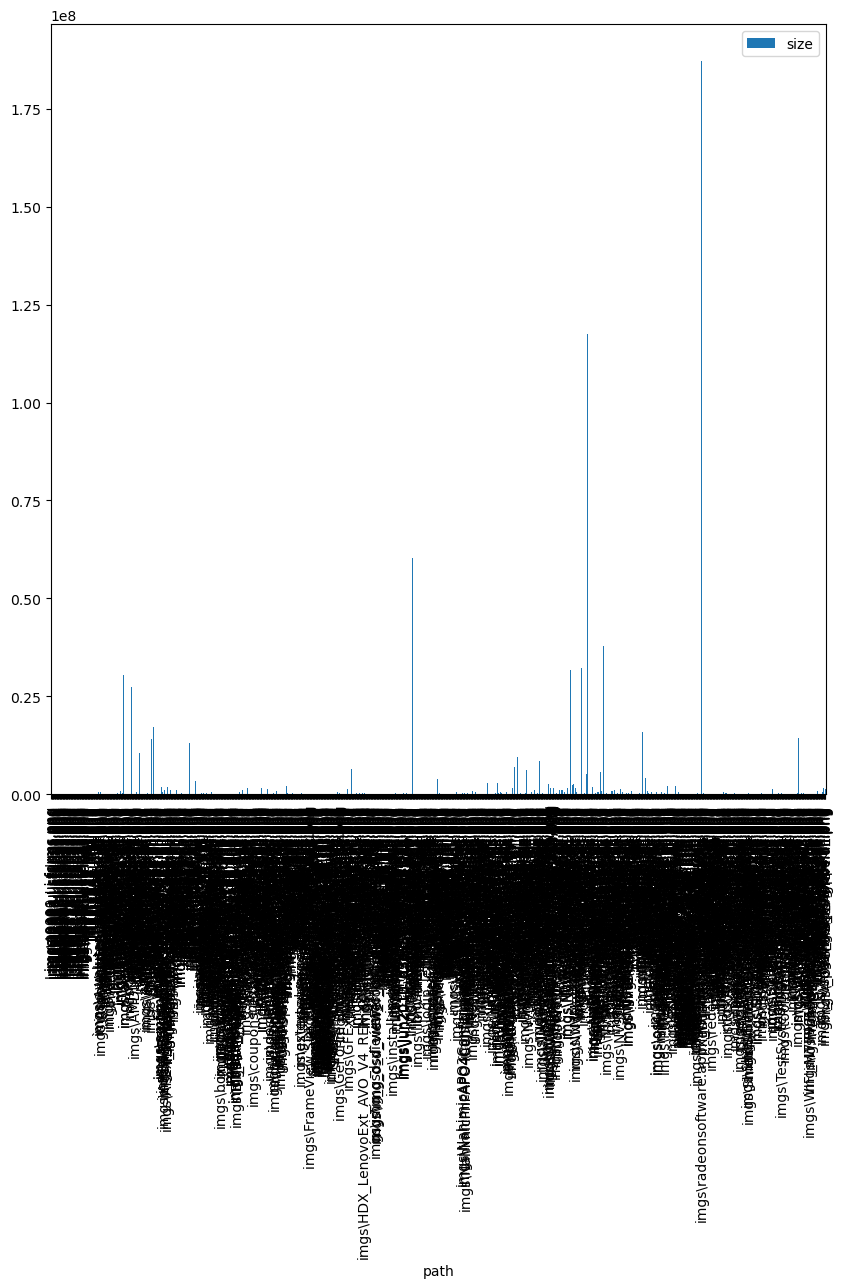

In [19]:
# Plot unstacked multiple columns such as population and year from DataFrame
df.plot(x="path", y=["size"],
        kind="bar", figsize=(10, 10))
# Display plot
plt.show()

In [13]:
# df['width'] = df.path.apply(lambda x: getImageWidthSize(x))
# df


C:\Users\genem\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (111323601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\genem\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (132457081 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


DecompressionBombError: Image size (187142400 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [49]:
math.sqrt(178956970)

13377.479957002364

# Reference
1 Hsiao, S.-C., Kao, D.-Y., Liu, Z.-Y., & Tso, R. (2019). Malware image classification using one-shot learning with Siamese networks. Procedia Computer Science, 159, 1863–1871. https://doi.org/10.1016/j.procs.2019.09.358

2 Bensaoud, A., & Kalita, J. (2022). Deep multi-task learning for malware image classification. Journal of Information Security and Applications, 64(103057), 103057. https://doi.org/10.1016/j.jisa.2021.103057

3 Kumar, S., Janet, B., & Neelakantan, S. (2024). IMCNN:Intelligent Malware Classification using Deep Convolution Neural Networks as Transfer learning and ensemble learning in honeypot enabled organizational network. Computer Communications, 216, 16–33. https://doi.org/10.1016/j.comcom.2023.12.036

4 AHMAD AZAB , (Member, IEEE), AND MAHMOUD KHASAWNEH , (Member, IEEE). (2020, June 1). MSIC: Malware Spectrogram Image Classification. Ieee.Org. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9104999